# Bioinformatics Vignette: Using K-Nearest Neighbors and Binary Decision Tree Algorithms to Predict Enzyme Function from Protein Sequences

## *Vignette Author*: Ayomikun Akinrinade

<img src="./ayomikun_akinrinade_vignette_picture.jpeg" width="200" align="left" style="margin: 0px 10px 0px 0px;" description="A picture of Ayomikun Akinrinade, the author of this vignette.">

## About Me
My interests primarily lie in evolutionary biology, specifically the morphological evolution of fishes (the most diverse group of vertebrates on earth!). I have been interested in programming for at least ten years, as of writing this vignette, and in discovering my passion for biology, I've developed a curiosity for how we can apply computer science methods to biology. In this vignette, I've shown one way that we can use machine learning to help find solutions in biology. I hope to apply similar techniques to my own research in the future. I similarly hope that you, the reader, will take the knowledge from this chapter and vignette, expand on it, and create a project that you find interesting.

## Background

Proteins are responsible for carrying out most enzymatic activities in cells. As such, proteins are a subject frequently under the (metaphorical) microscope of bioinformaticians. Applications range from predicting protein structure (e.g., AlphaFold developed by Google's DeepMind) to predicting protein function. This vignette will focus on latter of these two. *Note however, that protein function is determined by protein structure and shape.*


In this vignette, we will be focusing on using amino acid sequences to classify proteins according to their enzymatic function. We will do this using data from the Research Collaboratory for Structural Bioinformatics' Protein Data Base (PDB). From the PDB, we have both the protein sequence data and the known function. We need the sequence data so we can create features that our classfication algorithms will be able to interpret, and we need the known function in order for the algorithm to learn how to predict function from a new sequence. We are going to focus on 6 major enzyme classes: hydrolase, transferase, oxidoreductase, lyase, isomerase, ligase. 

We will be comparing two different machine learning algorithms: 1) a k-nearest neighbors classifier, and 2) a binary decision tree.

## Analysis

### Import Libraries

First we'll import the libraries we need. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from zipfile import ZipFile
from os import listdir

np.random.seed(7) # this is so we have consistent results between users; feel free to change this number to see what happens to our results at the end

### Unzip and Import Sequence and Function Data

Next, we load protein sequence and function data as pandas DataFrames. 

One small difficulty is that the sequence data file is 120MB, which is too large to store on GitHub directly. Therefore I had to upload it as a compressed .zip file. We can first uncompress it, to create a `pdb_data_seq.csv` file, and then load that `.csv` file as a pandas DataFrame as usual.

In [2]:
#Extract the zip file into a text file of sequence data
zipfile = ZipFile('./input/pdb_data_seq.zip')
zipfile.extract(member = 'input/pdb_data_seq.csv',path = './')

#Check that the unzipped file is in the input directory
print("We have these files in our input directory:",listdir('./input'))

We have these files in our input directory: ['.DS_Store', 'pdb_data_seq.zip', 'pdb_data_seq.csv', 'pdb_data_no_dups.csv']


In [3]:
#Load the sequence data as a pandas dataframe
all_seqs_df = pd.read_csv('./input/pdb_data_seq.csv')

#Load the protein function data as a pandas dataframe
all_charcs_df = pd.read_csv('./input/pdb_data_no_dups.csv')

### Examine the data

Next, we'll take a look at each dataframe to make sure we understand the form of the data.

In [4]:
#Show the first 5 rows of the sequence dataframe
all_seqs_df.head()


,structureId,chainId,sequence,residueCount,macromoleculeType
0,100D,A,CCGGCGCCGG,20,DNA/RNA Hybrid
1,100D,B,CCGGCGCCGG,20,DNA/RNA Hybrid
2,101D,A,CGCGAATTCGCG,24,DNA
3,101D,B,CGCGAATTCGCG,24,DNA
4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein


In [5]:
#Show the first 5 rows of the function dataframe
all_charcs_df.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear
0,100D,DNA-RNA HYBRID,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,"VAPOR DIFFUSION, HANGING DROP",NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",7.0,1994.0
1,101D,DNA,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,NaN,1995.0
2,101M,OXYGEN TRANSPORT,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0
3,102D,DNA,X-RAY DIFFRACTION,DNA,24,2.20,7637.17,"VAPOR DIFFUSION, SITTING DROP",277.0,2.28,46.06,"pH 7.00, VAPOR DIFFUSION, SITTING DROP, temper...",7.0,1995.0
4,102L,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,Protein,165,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0


In both the sequence and function dataframes up above, there are both proteins and other macromolecules like DNA or DNA/RNA hybrids. We'll need to filter our data to just the protein sequences.

### Limit the data to proteins

We saw that PDB data contains data on sturctures other than proteins, but we don't want those in our analysis. The code below drops all structures that aren't proteins from the sequence data and the function classification data.

In [6]:
protein_seqs = all_seqs_df[all_seqs_df.macromoleculeType == 'Protein'].reset_index(drop=True) 
protein_charcs = all_charcs_df[all_charcs_df.macromoleculeType == 'Protein'].reset_index(drop=True)

### Combine and Standardize the Data

We want the data all in a single dataframe. We'll do this using the dataframe `.join()` method. We also want to drop proteins with unknown function, and to ensure all the proteins have consistent capitalization.

In [7]:
protein_seqs = protein_seqs[['structureId','sequence']]
protein_charcs = protein_charcs[['structureId', 'classification']]

# combine potein characteristics df with their sequences using structureId
protein_all = protein_charcs.set_index('structureId').join(protein_seqs.set_index('structureId'))
protein_all = protein_all.dropna()

# capitalize all classification values to avoid missing any values in the next step
protein_all.classification = protein_all.classification.str.upper()

# drop all proteins with an unknown function; note -- the tilde ~ returns the inverse of a filter
data = protein_all[~protein_all.classification.str.contains("UNKNOWN FUNCTION")]

#### Paring down our sequences
In the following code, we drop all types of proteins that don't have more than 800 instances in the PDB. We also drop all of the duplicates of structures.


In [8]:
class_count = protein_all.classification.value_counts()
functions = np.asarray(class_count[(class_count > 800)].index)
data = protein_all[protein_all.classification.isin(functions)]
data = data.drop_duplicates(subset=["classification","sequence"])
data.head()

,classification,sequence
structureId,,
101M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
102M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
104M,OXYGEN TRANSPORT,VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...
106M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
109M,OXYGEN TRANSPORT,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


#### Drop all sequences that aren't enzymes

Notice in the head of our data, we see proteins that aren't enzymes (e.g., oxygen transport proteins). So we need to remove these in order to continue.

In [9]:
data.loc[~data['classification'].str.contains('ASE'), 'classification'] = 'OTHER'
data = data.loc[~data['classification'].str.contains("OTHER")]
data.loc[data['classification'].str.contains('TRANSFERASE/TRANSFERASE INHIBITOR'), 'classification'] = 'TRANSFERASE'
data.loc[data['classification'].str.contains('OXIDOREDUCTASE/OXIDOREDUCTASE INHIBITOR'), 'classification'] = 'OXIDOREDUCTASE'
data.loc[data['classification'].str.contains('HYDROLASE/HYDROLASE INHIBITOR'), 'classification'] = 'HYDROLASE'

#### Display how many of each type of enzyme class we have

In [10]:
print(data.classification.value_counts())

HYDROLASE         14716
TRANSFERASE       10361
OXIDOREDUCTASE     7591
LYASE              2580
ISOMERASE          1610
LIGASE             1534
Name: classification, dtype: int64


#### Let's look at what our data now looks like.

In [11]:
data

,classification,sequence
structureId,,
10GS,TRANSFERASE,PPYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKAS...
117E,HYDROLASE,TYTTRQIGAKNTLEYKVYIEKDGKPVSAFHDIPLYADKENNIFNMV...
11AS,LIGASE,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...
11BA,HYDROLASE,KESAAAKFERQHMDSGNSPSSSSNYCNLMMCCRKMTQGKCKPVNTF...
11GS,TRANSFERASE,MPPYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKA...
...,...,...
9ATC,TRANSFERASE,ANPLYQKHIISINDLSRDDLNLVLATAAKLKANPQPELLKHKVIAS...
9ATC,TRANSFERASE,QVEAIKRGTVIDHIPAQIGFKLLSLFKLTETDQRITIGLNLPSGEM...
9GAA,HYDROLASE,TTNKPIVLSTWNFGLHANVEAWKVLSKGGKALDAVEKGVRLVEDDP...


### Feature Creation

We are going to use a machine learning workflow to classify protein function from sequence, similar to having a classifier try to predict the name of a fruit from its properties. In order for a machine learning algorithm to classify our proteins, we need to create features that the computer can recognize. The same way, in order for us to classify different fruits, we would need features like color, shape, and size.

### Amino Acid Composition

We will use the Amino Acid composition of protein sequences as the data for our machine learning classifiers. To do this, we basically have to calculate the percentage of each amino acid in each protein sequence.

#### Create function to convert amino acid sequence string into a list of percentages

This next section of code defines a function that:
1. creates a list of the amino acids
2. makes a function that convert the amino acid sequence, seen in our previous step, into a list of percentages (e.g., [0.02, 0.13, 0.08, ...])

In [12]:
def amino_acid_composition(seq):
    """
    Returns a list of the percentages of each amino acid.
    seq -- a string representing an amino acid sequence
    """
    aa_list = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
    aac = []
    for i in aa_list:
        aac.append(seq.count(i)/len(seq))
    return aac

#### Build a new dataframe of the amino acid compositions, and one for enzyme classes
This next step uses the `amino_acid_composition()` function on the enzyme sequences, and stores the result in the AAC column (**AAC** stands for **A**mino **A**acid **C**omposition). After that, we drop the sequences because we now have the amino acid compositions in their place. We then keep the enzyme classes in a seperate dataframe for the Classification step later on.

In [13]:
data['AAC'] = data['sequence'].apply(amino_acid_composition)
data.drop(columns='sequence', inplace=True)
data_classes = data['classification']
data.head(10)

,classification,AAC
structureId,,
10GS,TRANSFERASE,"[0.07177033492822966, 0.03827751196172249, 0.0..."
117E,HYDROLASE,"[0.07692307692307693, 0.02097902097902098, 0.0..."
11AS,LIGASE,"[0.08787878787878788, 0.05757575757575758, 0.0..."
11BA,HYDROLASE,"[0.06451612903225806, 0.03225806451612903, 0.0..."
11GS,TRANSFERASE,"[0.07142857142857142, 0.0380952380952381, 0.03..."
12GS,TRANSFERASE,"[0.07142857142857142, 0.0380952380952381, 0.03..."
177L,HYDROLASE,"[0.0975609756097561, 0.07317073170731707, 0.07..."
17GS,TRANSFERASE,"[0.0761904761904762, 0.0380952380952381, 0.038..."
19GS,TRANSFERASE,"[0.07177033492822966, 0.03827751196172249, 0.0..."


#### Expand list of amino acid compositions into columns
The next two sections of code are going to convert our AAC column in the previous step into a series of columns, each with the heading being each amino acid.

In [14]:
def build_amino_acid_dictionary(percentage_list):
    """
    Returns a dictionary with the keys being the list of amino acids (aa_list) and the value being the percentage
    list -- list of amino acids composition percentages
    """
    aa_list = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']    
    return dict(zip(aa_list,percentage_list))

In [15]:
data['dictAAC'] = data.AAC.apply(build_amino_acid_dictionary)
data = data.dictAAC.apply(pd.Series)
data.head(10)

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
structureId,,,,,,,,,,,,,,,,,,,,
10GS,0.071770,0.038278,0.038278,0.062201,0.019139,0.062201,0.047847,0.086124,0.009569,0.033493,0.153110,0.057416,0.009569,0.033493,0.052632,0.047847,0.043062,0.009569,0.057416,0.066986
117E,0.076923,0.020979,0.055944,0.080420,0.003497,0.024476,0.069930,0.055944,0.020979,0.094406,0.062937,0.101399,0.006993,0.038462,0.066434,0.045455,0.066434,0.020979,0.038462,0.048951
11AS,0.087879,0.057576,0.009091,0.072727,0.000000,0.060606,0.069697,0.087879,0.039394,0.042424,0.121212,0.045455,0.018182,0.030303,0.042424,0.066667,0.036364,0.024242,0.015152,0.072727
11BA,0.064516,0.032258,0.056452,0.032258,0.080645,0.048387,0.040323,0.048387,0.032258,0.024194,0.016129,0.112903,0.040323,0.024194,0.040323,0.120968,0.072581,0.000000,0.032258,0.080645
11GS,0.071429,0.038095,0.038095,0.061905,0.019048,0.061905,0.047619,0.085714,0.009524,0.033333,0.152381,0.057143,0.014286,0.033333,0.052381,0.047619,0.042857,0.009524,0.057143,0.066667
12GS,0.071429,0.038095,0.038095,0.061905,0.019048,0.061905,0.047619,0.085714,0.009524,0.033333,0.152381,0.057143,0.014286,0.033333,0.052381,0.047619,0.042857,0.009524,0.057143,0.066667
177L,0.097561,0.073171,0.073171,0.054878,0.012195,0.030488,0.048780,0.067073,0.006098,0.060976,0.097561,0.079268,0.030488,0.030488,0.018293,0.036585,0.073171,0.018293,0.036585,0.054878
17GS,0.076190,0.038095,0.038095,0.061905,0.019048,0.061905,0.047619,0.085714,0.009524,0.033333,0.152381,0.052381,0.014286,0.033333,0.052381,0.047619,0.042857,0.009524,0.057143,0.066667
19GS,0.071770,0.038278,0.038278,0.062201,0.019139,0.062201,0.047847,0.086124,0.009569,0.033493,0.153110,0.057416,0.009569,0.033493,0.052632,0.047847,0.043062,0.009569,0.057416,0.066986


## Classification

#### Splitting our data into training data and test data
The train_test_split() function seperates our data in training data and test data.

In order to be able to tell whether our method is working, we want to split up the protein sequences into two sets. The first will be the 'training set' on which the machine learning classifiers learn to tell which protein functions go with which features of amino acid composition. The second will be the 'test set' which *wasn't* used in training. We'll use the test set to test the accuracy of our classifiers.

Going back to the fruit example mentioned earlier -- if we want to classify a fruit we haven't seen before, we need to be trained on what different fruits look like.

For example: if I place an apple and an orange in front of a toddler, the toddler will have no idea what kind of fruit it is. But, if I expose that toddler to different fruits, explaining what makes an apple an apple, what makes an orange an orange, etc., they will be able to classify whether any fruit I place in front of it is an apple, an orange, etc. That is similar to our training data.

In addition, the training data and test data need to be different in order to test if our classifiers are truly predicting the function.

Again, going back to the fruit example: if we show that same toddler a red apple they have already seen before, and ask them if that exact same piece of fruit is an apple, we are simply testing memory and not whether it can infer whether any given fruit is an apple or orange. On the other hand if we show them a different type of apple (maybe green rather than red), we can really see if they get the idea of what makes an apple an apple.

Helpfully, scikit-learn already has a function for splitting up training and test data called `train_test_split`.

In [16]:
#Split data into training and test sets
X = data
y = data_classes
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85)

## Train and Test our Classifiers

Now that we have training and test datasets with known amino acid compositions and enzymatic functions, we can use them to train and then test any machine learning algorithms we'd like to try out. In this vignette we'll use two approaches: a k-nearest neighbors classifier and a binary decision tree.

### K-Nearest Neighbors Classifier

#### Quick Explanation

A k-nearest neighbors classifier is a supervised classification algorithm that plots your on axes of a given number of dimensions. The amount of dimensions depends on how many dimensions your input data is in (e.g., input data with two traits to classify on, will create k-nearest neighbors classifier that plots data in two dimensions). Displayed below is an example to illustrate how a k-nearest neighbors classifier works. Here we have two dimensional data and the purple dot in the center is the point we are trying to classify. Surrounding our point are points with known classification. A k-nearest neighbors classifier will count how many of each class is in the k-nearest neighbors and make a decision based on which class makes up the majority. We can see that when *k*=1, we would decide that our point is in Class B. When *k*=3, Class A, and when *k*=5, Class B again. 

Note: when we are choosing our number for *k*, we never choose an even number because if there are an equal number of Class A and Class B in our sample, we can end up with an equal number of each, which doesn't allow the classifier to make a decision.


<img src="./knnexample.png" width=600px align="center" description="A vertebrate binary decision tree">


In [17]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)

knn_predictions = knn.predict(X_test)
knn_score = accuracy_score(y_test, knn_predictions)
print(f'Classification accuracy (kNN): {knn_score}')

Classification accuracy (kNN): 0.7628060427157493


### Binary Decision Tree

#### Quick Explanation

A binary decision tree is another supervised classification algorithm that makes a "tree" of questions that help the algorithm make decision on what it is trying to categorize. Displayed below is an example to illustrate how a binary decision tree could be used to classify some drinks. The complexity of a binary decision tree can be explained by the number of nodes (or questions) that are needed to classify any given object. In this case simple example, the number of nodes is 2. The next section of code will call the binary decision tree classifier, learn from our training data, predict the classification of the test data and and output the accuracy of the predictions.

For further explanation, Michael Galarnyk from Towards Data Science has a great explanation of binary decision trees [here](https://towardsdatascience.com/understanding-decision-trees-for-classification-python-9663d683c952).

<img src="./bdtexample.png" width=800px align="center" description="A vertebrate binary decision tree">


In [18]:
bdt = tree.DecisionTreeClassifier()
bdt.fit(X_train, y_train)

bdt_predictions = bdt.predict(X_test)
bdt_score = accuracy_score(y_test, bdt_predictions)
print(f'Classification accuracy (BDT): {bdt_score}')

Classification accuracy (BDT): 0.6379579788157667


## Comparing the classifiers

#### Making a graph of the scores for each classifier

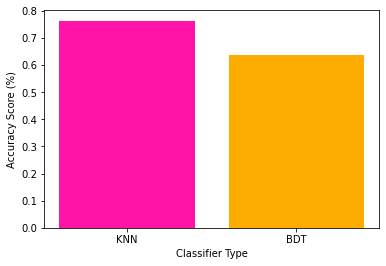

In [19]:
accuracy_dictionary = {'KNN': knn_score, 'BDT': bdt_score}
keys = accuracy_dictionary.keys()
values = accuracy_dictionary.values()
magenta = "#ff13a8"
orange = "#fdad01"
plt.bar(keys, values, color=[magenta, orange])
plt.xlabel('Classifier Type')
plt.ylabel('Accuracy Score (%)')
plt.show()

In [20]:
for k,v in accuracy_dictionary.items():
    print(f'Accuracy of {k} is ~{round(v*100,1)}%')

Accuracy of KNN is ~76.3%
Accuracy of BDT is ~63.8%


We can see above that the k-nearest neighbors classifer is a better predictor of enzyme function than a binary decision tree in this example.

## Exercises

1. Try removing the "np.random.seed(7)" line from the code and see what results you get for the classification steps

2. Try changing the number of neighbors used in the k-Nearest Neighbors Classifier. Does the accuracy change?

3. Use a for loop to automate trying out different numbers of neighbors with k-Nearest Neighbors, and select the best one based on its test accuracy.

4. The bdt.tree_.node_count property of the binary decision tree says how many nodes were needed for the classifier to make a decision. Try using it to find this out after the binary decision tree classifier has been made.

5. The [scikit-learn library](https://scikit-learn.org/stable/) has many other classifiers besides k-nearest neighbors and binary decision trees. Research one of them and try applying it to our dataset.

## [Reading Responses & Feedback](https://docs.google.com/forms/d/e/1FAIpQLSeUQPI_JbyKcX1juAFLt5z1CLzC2vTqaCYySUAYCNElNwZqqQ/viewform?usp=pp_url&entry.2118603224=Bioinformatics+Vignette+-+Ayomikun+Akinrinade+-+Using+k-Nearest+Neighbor+and+Binary+Decision+Tree+Algorithms+to+Predict+Enzyme+Function+from+Protein+Sequences)

## Further Reading

- The scikit-learn documentation is very useful for finding example machine learning methods
https://scikit-learn.org/stable/

- You can read the original description of the protein data bank (PDB) here:

Helen M. Berman, John Westbrook, Zukang Feng, Gary Gilliland, T. N. Bhat, Helge Weissig, Ilya N. Shindyalov, Philip E. Bourne, The Protein Data Bank, Nucleic Acids Research, Volume 28, Issue 1, 1 January 2000, Pages 235–242, https://doi.org/10.1093/nar/28.1.235

## Acknowledgements

Thanks to Shahir Kottilingal (https://www.shahirk.com/) for compiling the dataset used for this vignette, which can be found at: https://www.kaggle.com/shahir/protein-data-set